From implicit distance measurements to explicit delineation of **decision regions**, whose boundaries are called **decision boundaries**.

Casts the problem into supervised classification...

### Simple linear discriminant functions for binary classification


In [9]:
# In order to plot figures inline in Jupyter Notebook, 
# we need to run this. But please ignore this in Colab.
%matplotlib inline

In [2]:
# Start with some dummy data points.
import numpy as np
import matplotlib.pyplot as plt

# You can define a function to create your dummy dataset.
def dummyData(add_outliers=False, add_class=False):
    x0 = np.random.randn(50, 2) * 0.7 + np.array([2.0, 0.0])
    x1 = np.random.randn(50, 2) * 0.5 + np.array([0.0, -1.0])
    if add_outliers:
        x_1 = np.random.normal(size=10).reshape(-1, 2) + np.array([5., 10.])
        return np.concatenate([x0, x1, x_1]), np.concatenate([np.zeros(25), np.ones(30)]).astype(np.int)
    if add_class:
        x2 = np.random.normal(size=50).reshape(-1, 2) + 3.
        return np.concatenate([x0, x1, x2]), np.concatenate([np.zeros(25), np.ones(25), 2 + np.zeros(25)]).astype(np.int)
    return np.concatenate([x0, x1]), np.concatenate([np.zeros(len(x0)), np.ones(len(x1))]).astype(np.int)

# Then, try to call the function to create some data.
x_train, y_train = dummyData()

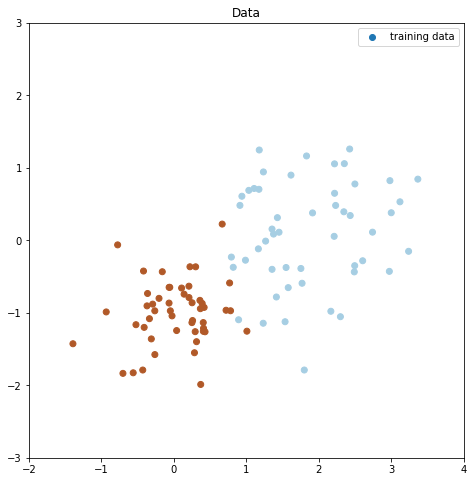

In [3]:
# Visualize the dummy dataset.

plt.figure(figsize=(10,8))
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='Paired', label='training data')
plt.axis([-2, 4, -3, 3])
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Data')
plt.legend()

In [4]:


import functools
import itertools

def encode(y):
    """
    Encode class index into one-of-k code
    Parameters
    ----------
    class_indices : (N,) np.ndarray
        non-negative class index
        elements must be integer in [0, n_classes)
    Returns
    -------
    (N, K) np.ndarray
        one-of-k encoding of input
    """
    n_classes = np.max(y) + 1

    return np.eye(n_classes)[y]


def fit(X, y):
    """
    Least squares fitting for classification parameters.
    When y is class labels, least square is equivalent to LDA.
    ----------
    X : (N, D) np.ndarray
        training independent variable
    y : (N,) or (N, K) np.ndarray
        training dependent variable
        in class index (N,) or one-of-k coding (N,K)
    """
    if y.ndim == 1:
        y = encode(y)
    W = np.linalg.pinv(X) @ y
    return W


def classify(X, W):
    """
    Classify input data.
    ----------
    X : (N, D) np.ndarray
        independent variable to be classified
    W : (D,) or (D, K) np.ndarray
    -------
    Return
    (N,) np.ndarray
        class index for each input
    """
    return np.argmax(X @ W, axis=-1)

def transform(x, degree):
    # Transforms input array with polynomial features
    # x : (sample_size, n) ndarray
    # Output : (sample_size, 1 + nC1 + ... + nCd) ndarray

    if x.ndim == 1:
        x = x[:, None]
    x_t = x.transpose()
    features = []
    for degree in range(1, degree + 1):
        for items in itertools.combinations_with_replacement(x_t, degree):
            features.append(functools.reduce(lambda x, y: x * y, items))
    return np.asarray(features).transpose()



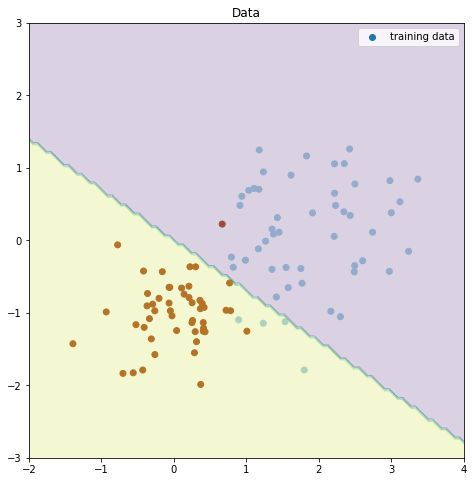

In [5]:
# Train the model by using function fit defined above, and then apply the trained model to predict everywhere in the input space X.

x1_test, x2_test = np.meshgrid(np.linspace(-2, 4, 100), np.linspace(-3, 3, 100))
x_test = np.array([x1_test, x2_test]).reshape(2, -1).T

X_train = transform(x_train, 1)
X_test = transform(x_test, 1)

weights = fit(X_train, y_train)
y = classify(X_test, weights)


# Visualization
plt.figure(figsize=(10,8))
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='Paired', label='training data')
plt.contourf(x1_test, x2_test, y.reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 7))
plt.axis([-2, 4, -3, 3])
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Data')
plt.legend()


### Probabilistic Discriminative Models: Logistic regression


In [6]:


def sigmoid(a):
    return np.tanh(a * 0.5) * 0.5 + 0.5

def fit(X, y, max_iter=100):
    """
    maximum likelihood estimation of logistic regression model
    Parameters
    ----------
    X : (N, D) np.ndarray
        training data independent variable
    t : (N,) np.ndarray
        training data dependent variable
        binary 0 or 1
    max_iter : int, optional
        maximum number of paramter update iteration (the default is 100)
    """
    w = np.zeros(np.size(X, 1))
    for _ in range(max_iter):
        w_prev = np.copy(w)
        y_bar = sigmoid(X @ w)
        grad = X.T @ (y_bar - y)
        hessian = (X.T * y_bar * (1 - y_bar)) @ X
        try:
            w -= np.linalg.solve(hessian, grad)
        except np.linalg.LinAlgError:
            break
        if np.allclose(w, w_prev):
            break
    return w

def proba(X, W):
    """
    compute probability of input belonging class 1
    Parameters
    ----------
    X : (N, D) np.ndarray
        training data independent variable
    Returns
    -------
    (N,) np.ndarray
        probability of positive
    """
    return sigmoid(X @ W)

def classify(X, W, threshold=0.5):
    """
    classify input data
    Parameters
    ----------
    X : (N, D) np.ndarray
        independent variable to be classified
    threshold : float, optional
        threshold of binary classification (default is 0.5)
    Returns
    -------
    (N,) np.ndarray
        binary class for each input
    """
    return (proba(X, W) > threshold).astype(np.int)

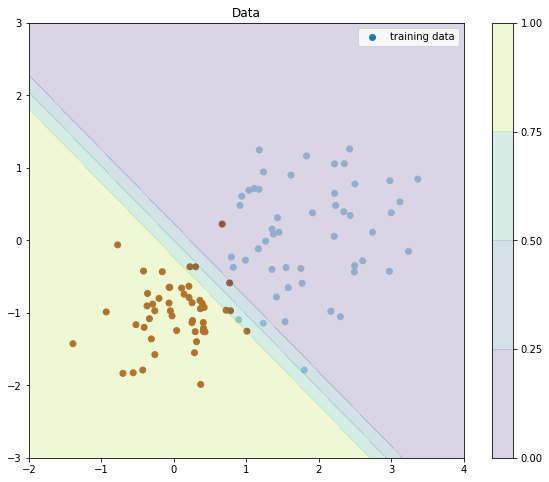

In [7]:


X_train = transform(x_train, 1)
X_test = transform(x_test, 1)

weights = fit(X_train, y_train)
y = proba(X_test, weights)

# Visualization
plt.figure(figsize=(10,8))
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='Paired', label='training data')
plt.contourf(x1_test, x2_test, y.reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 5))
plt.axis([-2, 4, -3, 3])
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Data')
plt.colorbar()
plt.legend()

### A non-statistical perspective: The Perceptron

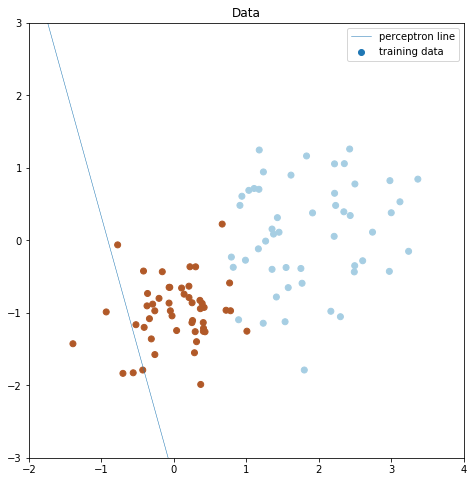

In [12]:


# Make a prediction with weights
def predict(point, weights):
    activation = np.dot(point, weights)
    return 1.0 if activation >= 0.0 else -1.0
 
# Estimate Perceptron weights using stochastic gradient descent
def train(x, y, l_rate, n_epoch):
    x = np.c_[np.ones(len(x))*(-1.0), x]
    weights = [0.0 for i in range(x.shape[1])]
    for epoch in range(n_epoch):
        for i, xi in enumerate(x):
            if predict(xi, weights)*y[i] <= 0:
                weights = weights + l_rate*xi*y[i]
    return weights


l_rate = 0.05
n_epoch = 200

weights = train(X_train, np.where(y_train <= 0, -1, 1), l_rate, n_epoch)

# Visualize the decision boundary/line.
# Given the weights, the decision line on the X plane can be defined by the function X*W = 0.
# Then the position of the decision line can be easily determined:
x1 = np.linspace(-3, 15, 200).reshape(-1,1)
x2 = (weights[0]+weights[1]*x1)/(-weights[2])

# Visualization
plt.figure(figsize=(10,8))
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='Paired', label='training data')
plt.plot(x1, x2, linewidth=.5, label='perceptron line')
plt.axis([-2, 4, -3, 3])
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Data')
plt.legend()


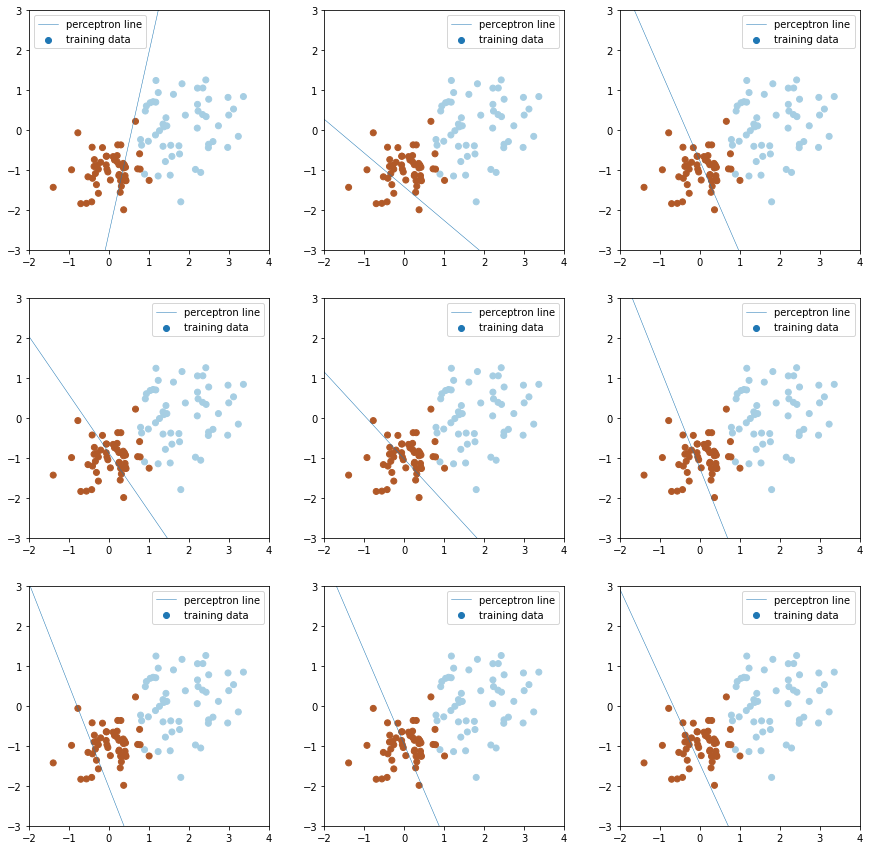

In [16]:
# You can even visualize how weights have been updated during some of the epochs.

# But first you need to re-write the training functionality to record trained weights in each epoch.
def train(x, y, l_rate, n_epoch):
    x = np.c_[np.ones(len(x))*(-1.0), x]
    weights_all = []
    weights = [0.0 for i in range(x.shape[1])]
    for epoch in range(n_epoch):
        for i, xi in enumerate(x):
            if predict(xi, weights)*y[i] <= 0:
                weights = weights + l_rate*xi*y[i]
                weights_all.append(weights)
    return weights_all

l_rate = 0.01
n_epoch = 100
weights_all = train(X_train, y_train*2-1, l_rate, n_epoch)


fig = plt.figure(figsize=(15,15))
for i in range(9):
    x1 = np.linspace(-3, 15, 200).reshape(-1,1)
    x2 = (weights_all[i*3][0]+weights_all[i*3][1]*x1)/(-weights_all[i*6][2])
    plt.subplot(3, 3, i+1)
    plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='Paired', label='training data')
    plt.plot(x1, x2, linewidth=.5, label='perceptron line')
    plt.axis([-2, 4, -3, 3])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()

In [17]:
# In machine learning, you also need to find a way to evaluate your model.
# Normally, a handy way to evaluate your model is to split your dataset into training and test sets, pretending like you have extra data to verify the performance of the trained model.

# You can define a function to split the dataset at hand.
def trainTestSplit(x, y):
    data = np.c_[x, y]
    np.random.shuffle(data)
    x_train = data[:int(0.7*len(data)), :2]  # 70% of data for training
    x_test = data[int(0.7*len(data)):, :2]  # 30% for testing
    y_train = data[:int(0.7*len(data)), 2:]  # 70% of data for training
    y_test = data[int(0.7*len(data)):, 2:]  # 30% for testing
    return x_train, y_train, x_test, y_test

# Apply the function to your data.
X_train, Y_train, X_test, Y_test = trainTestSplit(x_train, y_train)


In [18]:
# Now, you can define another fucntion to evaluate the model performance on the test dataset.
def accuracy(x_test, y_test, w):
    y_test = y_test.reshape((-1,))
    y_test = y_test*2-1
    x_test = np.c_[np.ones(len(x_test))*(-1.0), x_test]
    y_pred = []
    for i, xi in enumerate(x_test):
        y_pred.append(predict(xi, w))
    correct = 0
    for i in range(len(y_pred)):
        if y_test[i] == y_pred[i]:
            correct += 1
    return correct / float(len(y_test)) * 100.0

# Call and apply the function.

acc = accuracy(X_test, Y_test, weights)
print(acc)

93.33333333333333


In [20]:
# Introducing Python modules and packages

import numpy as np
from sklearn.linear_model import LogisticRegression, Perceptron



#log = LogisticRegression(C=1e5)
#log.fit(X_train, Y_train)

percep = Perceptron(tol=1e-3, random_state=0)
percep.fit(X_train, Y_train)
weights, bias = percep.coef_, percep.intercept_

C:\Users\Jon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


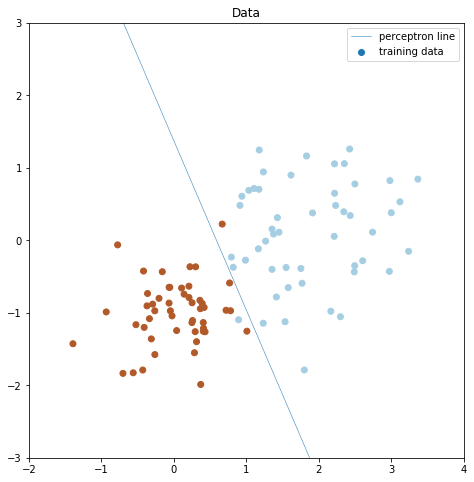

In [21]:
x1 = np.linspace(-3, 15, 200).reshape(-1,1)
x2 = (bias+weights[0,0]*x1)/(-weights[0,1])

# Visualization
plt.figure(figsize=(10,8))
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='Paired', label='training data')
plt.plot(x1, x2, linewidth=.5, label='perceptron line')
plt.axis([-2, 4, -3, 3])
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Data')
plt.legend()

In [1]:
# Real dataset

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.plot import show
from sklearn import cluster

# The data contains sample LULC areas around dutch provinces North Holland and Utrecht.
aoi = gpd.read_file('data/aoi_NL_5_classes.shp')
print (aoi.head())

# Below is a visualization of the sample LULC areas superimposed on a satellite image of part of the Netherlands
file_location = 'data/b5_2015.TIF'
b5_2020 = rasterio.open(file_location, nodata=0)

fig,ax = plt.subplots(1,1, figsize=(10,10))
show(b5_2020, ax=ax, cmap='gray', alpha=0.25)
aoi.plot(column='land_cover', legend=True, ax=ax, cmap='Set1')


     id   land_cover  class                                           geometry
0  None  Clear water     11  POLYGON ((638038.588 5776433.484, 637916.087 5...
1  None  Clear water     11  POLYGON ((638293.014 5776226.174, 638669.940 5...
2  None  Clear water     11  POLYGON ((642646.516 5779109.663, 643438.062 5...
3  None  Clear water     11  POLYGON ((658307.816 5795505.970, 659438.596 5...
4  None  Clear water     11  POLYGON ((617048.489 5789668.319, 617764.649 5...


In [2]:
import pandas as pd
lulc = pd.read_csv('data/stack_aoi_2015.csv')

# Subset for plotting speed
lulc_sub = lulc.sample(n=5000)
lulc_sub.head()

,Unnamed: 0,B1,B2,B3,B4,B5,B6,B7,aoi
6886,5065582,8108,8292,8702,8104,7899,7578,7497,11.0
7644,5930120,13092,13881,15464,16477,18132,19886,18462,21.0
2917,3066036,7830,7866,7972,7771,7979,7404,7374,11.0
3391,3615399,7373,7513,7805,7573,7766,7645,7589,11.0
5459,3793450,8182,8168,8738,8190,18382,12347,9293,61.0


In [3]:
# Prepare training data

import numpy as np
from scipy import ndimage
from sklearn.preprocessing import LabelBinarizer

X_train = np.c_[lulc_sub['B5'].values, lulc_sub['B6'].values]
Y_train = lulc_sub['aoi'].values.astype(int)

Y_dense = LabelBinarizer().fit_transform(Y_train)

file_list = ['data/b5_2015.TIF', 'data/b6_2015.TIF']  # List to store file names

# You can print to see how the file_list looks like
print(file_list)

# Read the files and stack them together by calling their names
# Use the 'for' loop to iterate over the names to read files
stack = np.array([])  # Empty array to store the stacked images
for file in file_list:
    img = ndimage.imread(file)  # Read each image file
    print(img.shape)  # Each time, also check the size of the image
    
    # In order to do clustering, image should be reshaped into a single column
    img_col = img.reshape(-1, 1)
    
    # Each time put the reshaped image into the stack
    stack = np.hstack((stack,img_col)) if stack.size else img_col
    # Also to check the size of the stack
    print(stack.shape)

['data/b5_2015.TIF', 'data/b6_2015.TIF']


C:\Users\Jon\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


(3434, 3221)
(11060914, 1)
(3434, 3221)
(11060914, 2)


In [4]:
# Train and predict on entire image

from sklearn.linear_model import LogisticRegression

log = LogisticRegression(multi_class='ovr')
Y_pred = log.fit(X_train, Y_train).predict(stack)


C:\Users\Jon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [5]:
# Map the predicted categories to original classes 

aoi['aoi_cat'] = pd.Categorical(aoi['class'])
classes = aoi.loc[:,['land_cover', 'aoi_cat']].drop_duplicates()
class_dict = {k:v for k,v in zip(classes.aoi_cat, classes.land_cover)}

#Y_pred_categ = np.array([class_dict[y] for y in Y_pred])

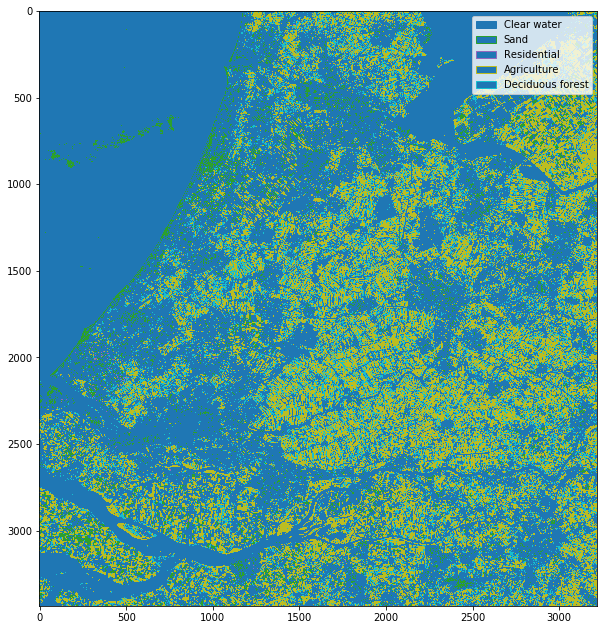

In [6]:
# 

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

row, col = img.shape  # Get the original dimensions of the image

plt.figure(figsize = (10,12))
im = plt.imshow(Y_pred.reshape(row, col), cmap='tab10')
# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(im.cmap(im.norm(key)), label=class_dict[key]) for key in class_dict]
# put those patched as legend-handles into the legend
plt.legend(handles=patches)  #, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)